In [2]:
! pip install segmentation_models_pytorch

In [3]:
from google.colab import drive
import os
import torch
import segmentation_models_pytorch as smp
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape, MultiPolygon
from PIL import Image

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


1. PAN (Pyramid Attention Network)

In [8]:
pan = smp.PAN(
    encoder_name = 'resnet34',
    encoder_weights = 'imagenet',
    in_channels = 4,
    classes = 1,
    activation='sigmoid'
    )

pan.load_state_dict(torch.load('/content/drive/MyDrive/PMML Models/Models/pan.pth', map_location=device))
pan.to(device)
_ = pan.eval()

2. U-Net

In [15]:
unet = smp.Unet(
    encoder_name = 'resnet34',
    encoder_weights = 'imagenet',
    in_channels = 4,
    classes = 1,
    activation='sigmoid'
    )

unet.load_state_dict(torch.load('/content/drive/MyDrive/PMML Models/Models/unet.pth', map_location=device))
unet.to(device)
_ = unet.eval()

3. FPN (Feature Pyramid Network)

In [17]:
fpn = smp.FPN(
    encoder_name = 'resnet34',
    encoder_weights = 'imagenet',
    in_channels = 4,
    classes = 1,
    activation='sigmoid'
    )

fpn.load_state_dict(torch.load('/content/drive/MyDrive/PMML Models/Models/fpn.pth', map_location=device))
fpn.to(device)
_ = fpn.eval()

4. DeepLabV3+

In [19]:
deeplab_v3plus = smp.DeepLabV3Plus(
    encoder_name = 'resnet34',
    encoder_weights = 'imagenet',
    in_channels = 4,
    classes = 1,
    activation='sigmoid'
    )

deeplab_v3plus.load_state_dict(torch.load('/content/drive/MyDrive/PMML Models/Models/deeplabv3.pth', map_location=device))
deeplab_v3plus.to(device)
_ = deeplab_v3plus.eval()

5. U-Net++

In [21]:
unetplusplus = smp.UnetPlusPlus(
    encoder_name = 'resnet34',
    encoder_weights = 'imagenet',
    in_channels = 4,
    classes = 1,
    activation='sigmoid'
    )

unetplusplus.load_state_dict(torch.load('/content/drive/MyDrive/PMML Models/Models/unetplusplus.pth', map_location=device))
unetplusplus.to(device)
_ = unetplusplus.eval()

In [30]:
# deforestation tiffs loading

deforestation_dir_path = '/content/local_deforestation_tiffs/deforestation_0.04498_-60.98425/images'
cloud_masks_1 = '/content/local_deforestation_tiffs/deforestation_0.04498_-60.98425/masks'

deforestation_dir_path2 = '/content/local_deforestation_tiffs/deforestation_3.63147_-58.19381/images'
cloud_masks_2 = '/content/local_deforestation_tiffs/deforestation_3.63147_-58.19381/masks'

deforestation_dir_path3 = '/content/local_deforestation_tiffs/deforestation_1.49389_-59.9342/images'
cloud_masks_3 = '/content/local_deforestation_tiffs/deforestation_1.49389_-59.9342/masks'

deforestation_images = [deforestation_dir_path, deforestation_dir_path2, deforestation_dir_path3]
cloud_masks = [cloud_masks_1, cloud_masks_2, cloud_masks_3]

In [31]:
#Definition of transforms and data loaders for training

mean = torch.tensor([0.485, 0.456, 0.406, 0.5])
std  = torch.tensor([0.229, 0.224, 0.225, 0.5])
preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Binary for mask (It's always 0 or 1)
mask_preprocess = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

In [32]:
class DeforestationCheck:
  """
  Class for checking deforestation. Includes construction of a mask ignoring the clouds with its parameters.

  Attributes:
  ignore_for (int) - number of deforestation detections in a row needed to alert about deforestation, additional measure to prevent random false positives
  shadow_cut_off (float) - maximum nir level for the shadow, mask ignores all the pixels with nir > shadow_cut_off
  cloud_min (float) - minimum blue level for the cloud, mask ignores all the pixels with blue < cloud_min

  Methods:
  process - main method for checking deforestation
  """
  def __init__(self, ignore_for=3, shadow_cut_off=0.05, cloud_min=0.15): # shadow cut_off - maximum nir level for the shadow
    self.ignore_for = ignore_for
    self.shadow_cut_off = shadow_cut_off
    self.cloud_min = cloud_min
    self.detection_count = None # full array of how many times have we detected non-forest
    self.forest = None # saving areas with forest in the first place

  def process(self, image_scaled, image_ts, scm, model, device):
    model.eval()
    img = image_ts.unsqueeze(0).to(device)

    with torch.no_grad():
      output = model(img)
      pred_mask = (output > 0.5).float().cpu().squeeze().numpy()

    if self.detection_count is None:
      self.detection_count = np.zeros(pred_mask.shape, dtype=int) # here, not in initialization to make sure the shape is the same
      self.forest = np.zeros(pred_mask.shape, dtype=bool)

    # in blue channel forests and all vegeation reflect up to .15-.2, the clouds should be above .4 hence the default value
    clouds_threshold = (image_scaled[0] > self.cloud_min) # blue -> 1st channel (sentinel goes B01-aerosol (not included in the dataset), B02 - Blue, B03 - Green, B04 - Red, ..., B08 -NIR)
    clouds_scm = np.isin(scm, [8,9,10,11])

    # cloud shadow handling, looking for areas below nir for shadows, cut-off by try and error, could go up to about .15
    shadows_threshold = (image_scaled[3] < self.shadow_cut_off) # nir -> 4th channel
    shadows_scm = np.isin(scm, 3)

    clouds = clouds_threshold | clouds_scm
    shadows = shadows_threshold | shadows_scm

    no_forest_clear = (pred_mask == 0) & (~shadows) & (~clouds) # definite no forest - according to model, not part of the shadows nor clouds
    is_forest_clear = (pred_mask == 1) & (~shadows) & (~clouds) # the same with forest

    valid_change = no_forest_clear & self.forest

    self.detection_count[valid_change] += 1 # counting deforestation occurences for each pixel
    self.forest[is_forest_clear] = True #remembering where the forest is
    self.detection_count[is_forest_clear] = 0 #resetting the counter if forest is detected

    # self.forest[(pred_mask == 1) & (~shadows) & (~clouds)] = True

    # valid_change = (pred_mask == 0) & (~shadows) & (~clouds) & self.forest

    # self.detection_count[valid_change] += 1
    # self.detection_count[(pred_mask == 1) | shadows | clouds] = 0

    deforestation_mask = (self.detection_count >= self.ignore_for)

    return pred_mask, deforestation_mask, self.detection_count

In [33]:
# we got some warnings that weren't distrubing the code, here to not print them
import logging

In [28]:
# base for writing tiff https://rasterio.readthedocs.io/en/latest/topics/writing.html
# https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html

def visualize_deforestation_detection(image, pred_mask, detection, deforestation):

  # rgb from singular bands
  rgb = np.stack([image[2], image[1], image[0]], axis=-1)
  rgb = np.clip(rgb * 3, 0, 1) # brightening

  fig, ax = plt.subplots(figsize=(20,8),ncols=4)

  ax[0].set_title("Original image")
  ax[0].imshow(rgb)
  ax[0].axis('off')

  ax[1].set_title("Prediction mask")
  ax[1].imshow(pred_mask)
  ax[1].axis('off')

  ax[2].set_title("Changes in forest detection count")
  im = ax[2].imshow(detection)
  fig.colorbar(im, ax=ax[2], fraction=0.046, pad=0.04)
  ax[2].axis('off')

  ax[3].set_title("Deforestation on orignal image")
  ax[3].imshow(rgb)
  ax[3].imshow(deforestation, cmap='Reds', alpha=.5)
  ax[3].axis('off')

  plt.tight_layout()

def find_deforestation(dir,dir_scm,model,device):
  rasterio.logging.getLogger().setLevel(logging.ERROR)
  finder = DeforestationCheck()
  imgs = sorted([f for f in os.listdir(dir) if f.endswith(('.tif', 'tiff'))]) # checking all files in the folder -- has to be one folder for each area with deforestation
  scms = sorted([f for f in os.listdir(dir_scm) if f.endswith(('.tif', 'tiff'))])

  for i in range(len(imgs)):
    img_path = os.path.join(dir,imgs[i])
    scm_path = os.path.join(dir_scm,scms[i])

    # in previous, regular classes without cloud handling raster transforms were perfored directly in the class,
    with rasterio.open(img_path) as img_src, rasterio.open(scm_path) as scm_src:
      profile = img_src.profile # tiff profile for further tiff-mask writing, tiff settings, crs etc.

      # image = img_src.read()
      # image = np.transpose(image, (1, 2, 0)) # changing the channel order, needed
      # image = image.astype(np.float32) / (10000.0)
      # image_ts = preprocess(image)

      image = img_src.read()
      image_scaled = image.astype(np.float32) / 10000.0
      image_for_model = np.transpose(image_scaled, (1, 2, 0))
      image_pil = Image.fromarray((image_for_model * 255).astype(np.uint8))
      image_ts = preprocess(image_pil)

      scm = scm_src.read(1)

      pred_mask, deforestation_mask, detection_count = finder.process(image_scaled,image_ts,scm,model,device)

      visualize_deforestation_detection(image_scaled, pred_mask, detection_count,deforestation_mask)

    if deforestation_mask.any():
      new_dir_name = f"Deforestation_{i}"
      if not os.path.exists(new_dir_name):
        os.mkdir(new_dir_name)

      profile.update(count=1, dtype='uint8', nodata=0, compress='lzw') # update for 0-1 mask

      with rasterio.Env(), rasterio.open(f"{new_dir_name}/mask.tif", 'w', **profile) as dest:
        dest.write(deforestation_mask.astype(np.uint8), 1)

      mask_shapes = shapes(deforestation_mask.astype(np.int16), mask=deforestation_mask, transform=profile['transform'])
      poly = MultiPolygon([shape(s) for s, v in mask_shapes])

      print(f"DEFORESTATION AT {poly.centroid.y}, {poly.centroid.x}, TIF MASK SAVED")


DEFORESTATION AT 1.513623661358172, -59.94182678410457, TIF MASK SAVED
DEFORESTATION AT 1.5107117322085046, -59.942430706735756, TIF MASK SAVED
DEFORESTATION AT 1.5054801979885417, -59.93800447765215, TIF MASK SAVED
DEFORESTATION AT 1.4959572943738046, -59.933192466517845, TIF MASK SAVED
DEFORESTATION AT 1.493256719280772, -59.93396492677846, TIF MASK SAVED


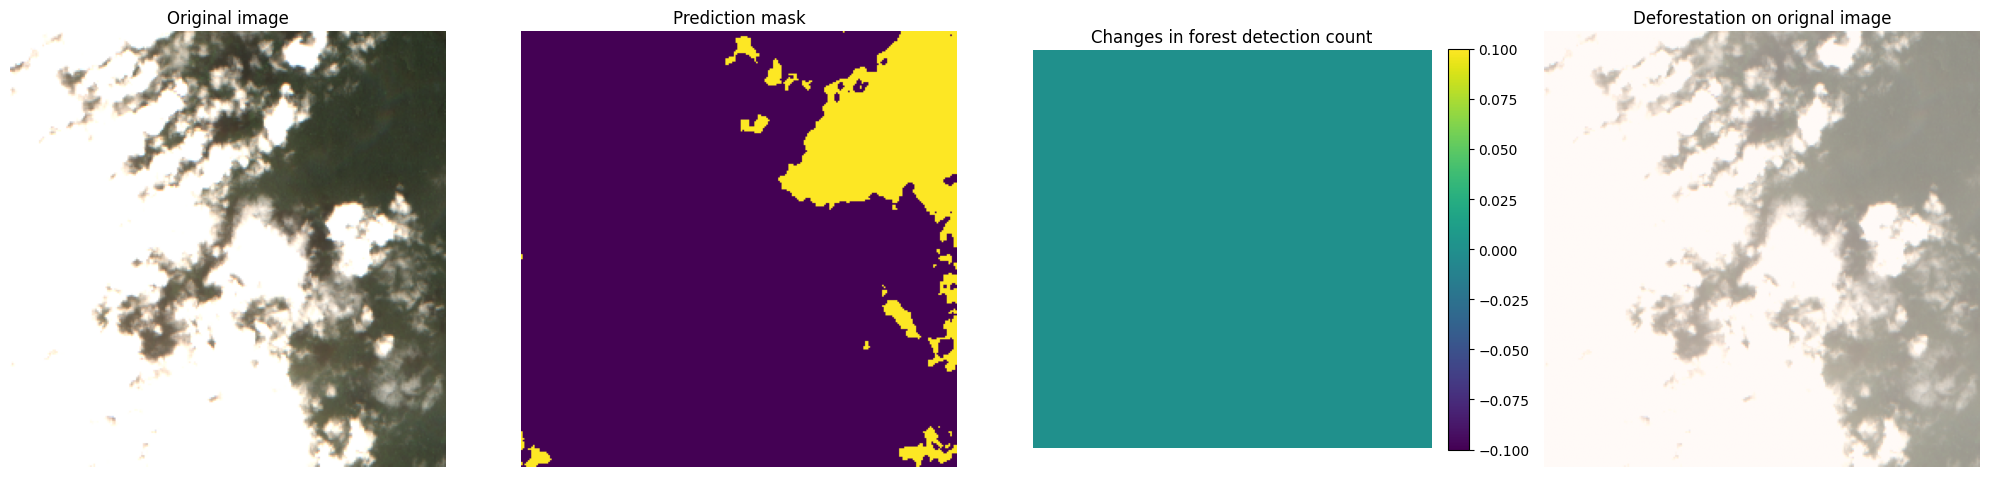

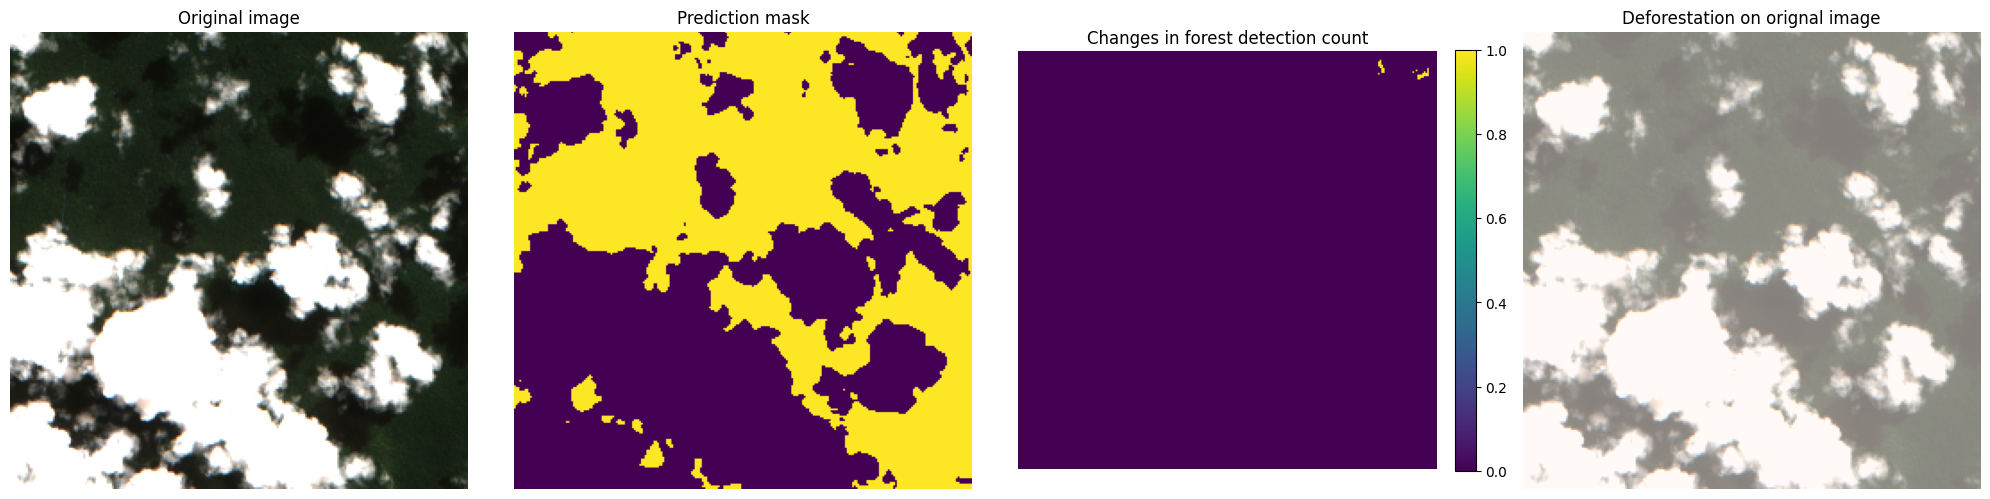

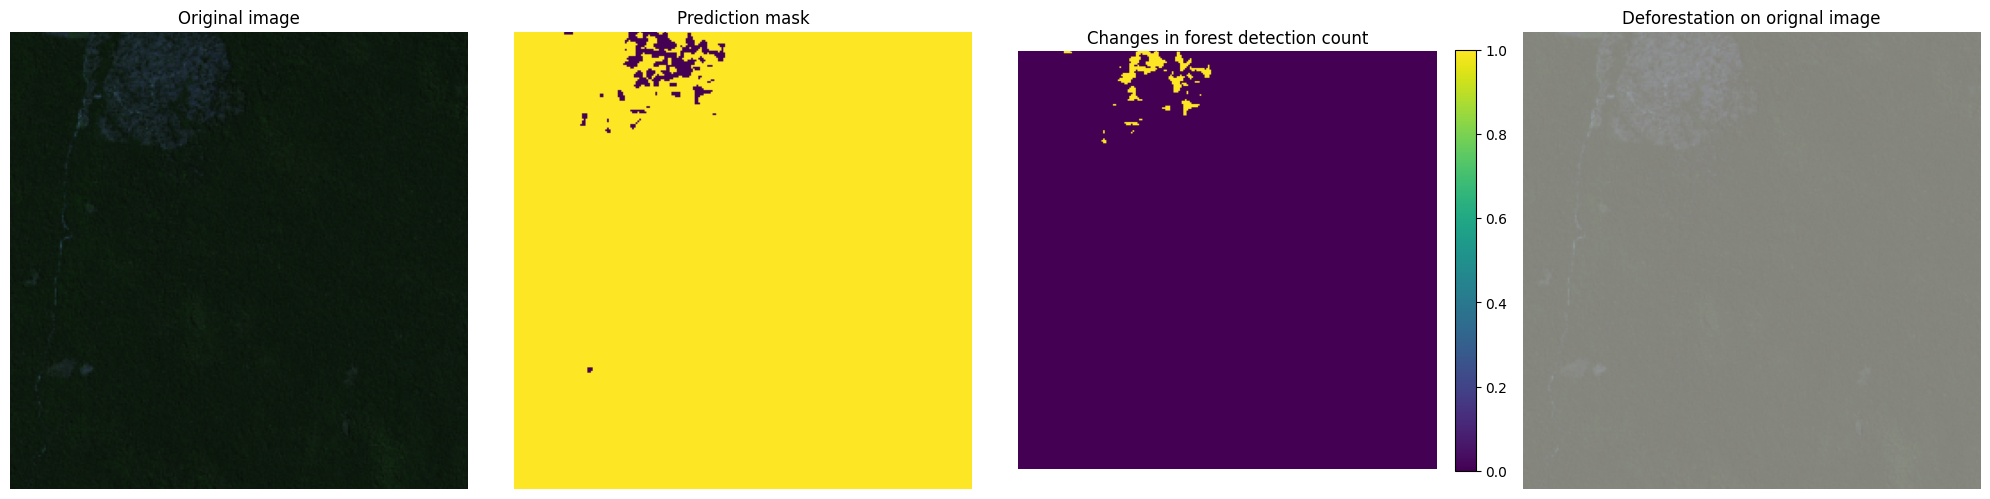

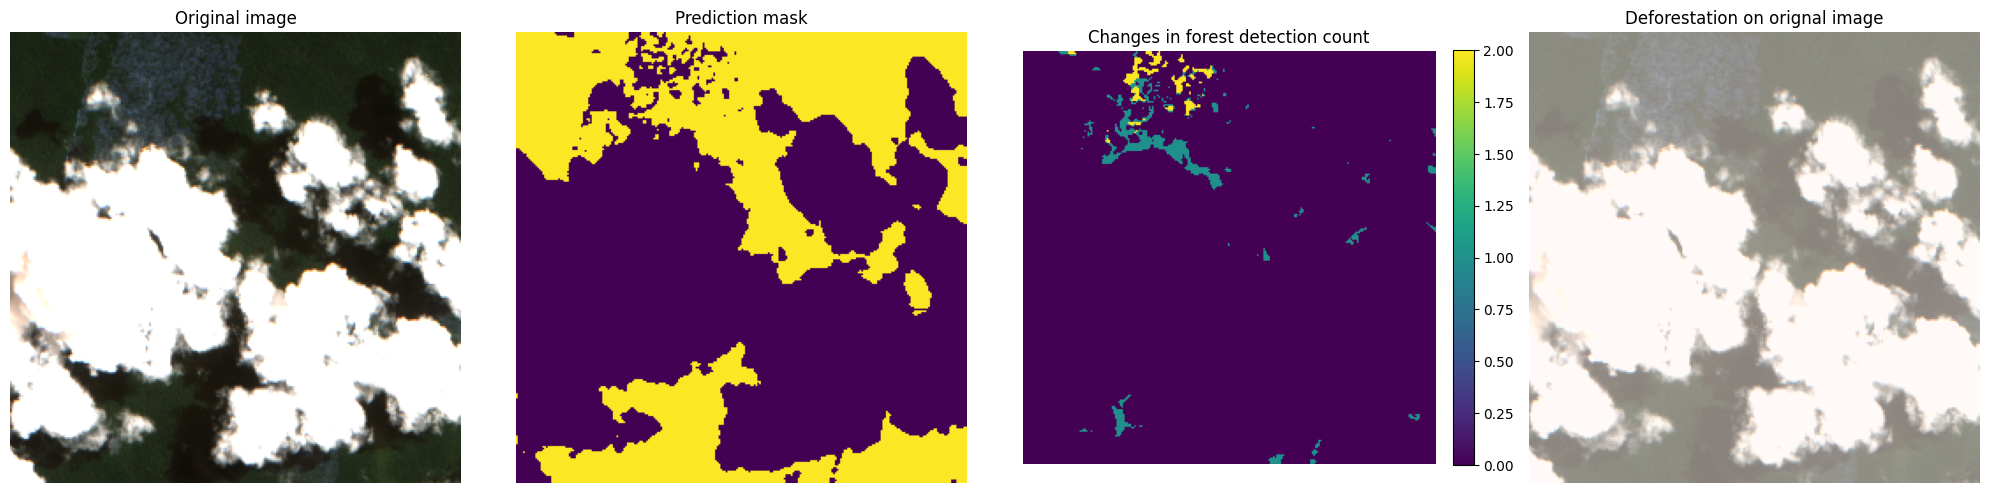

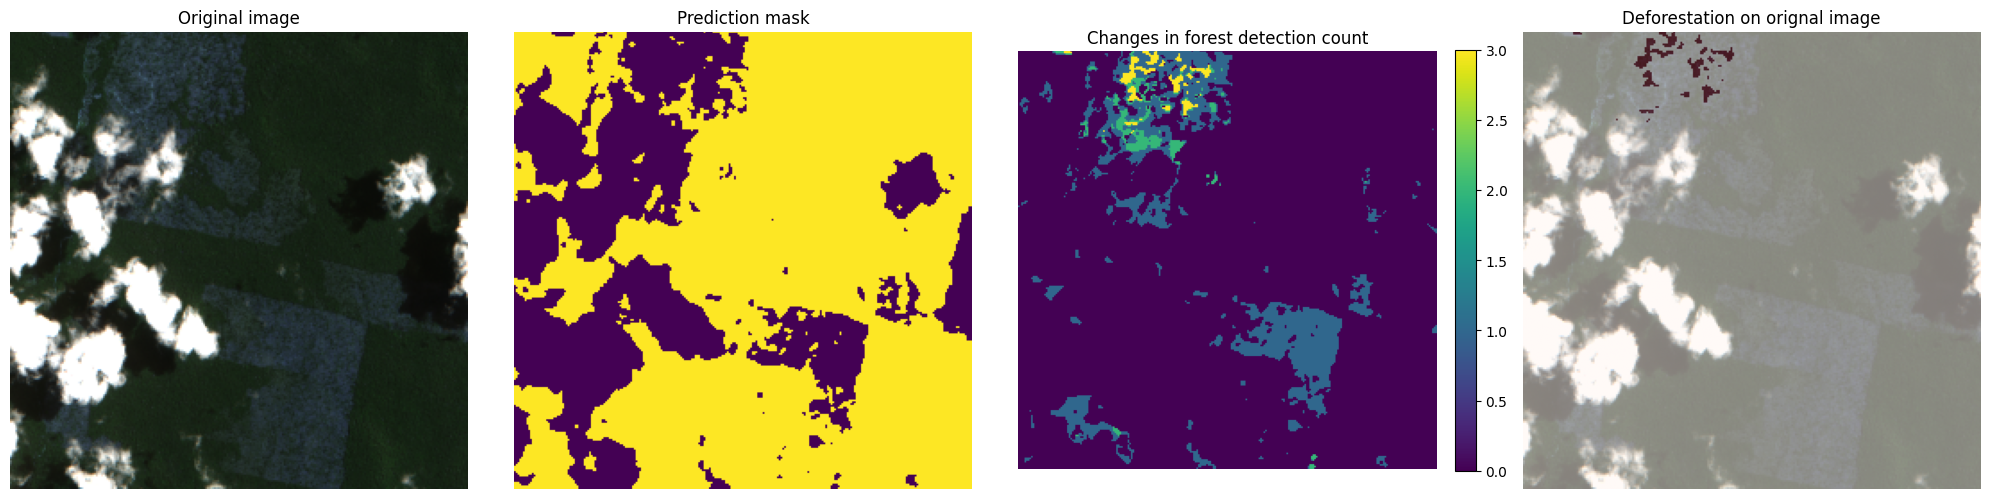

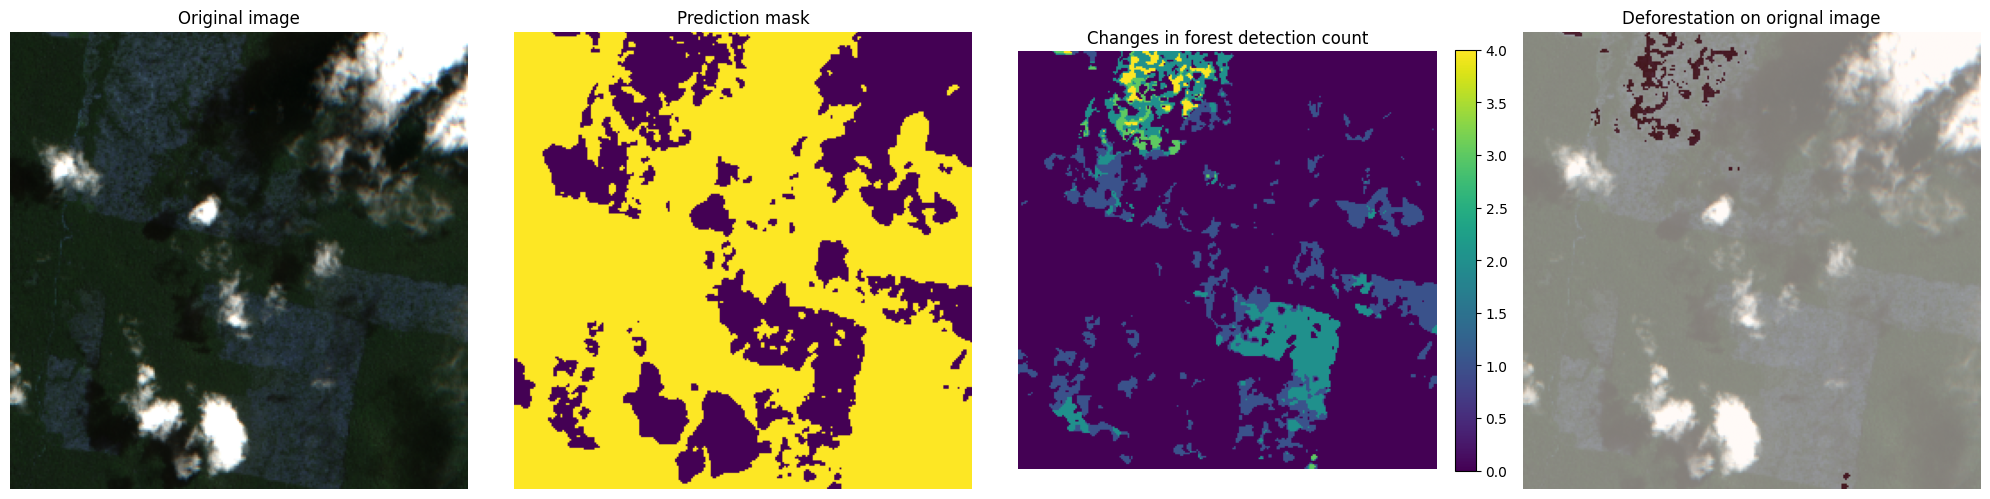

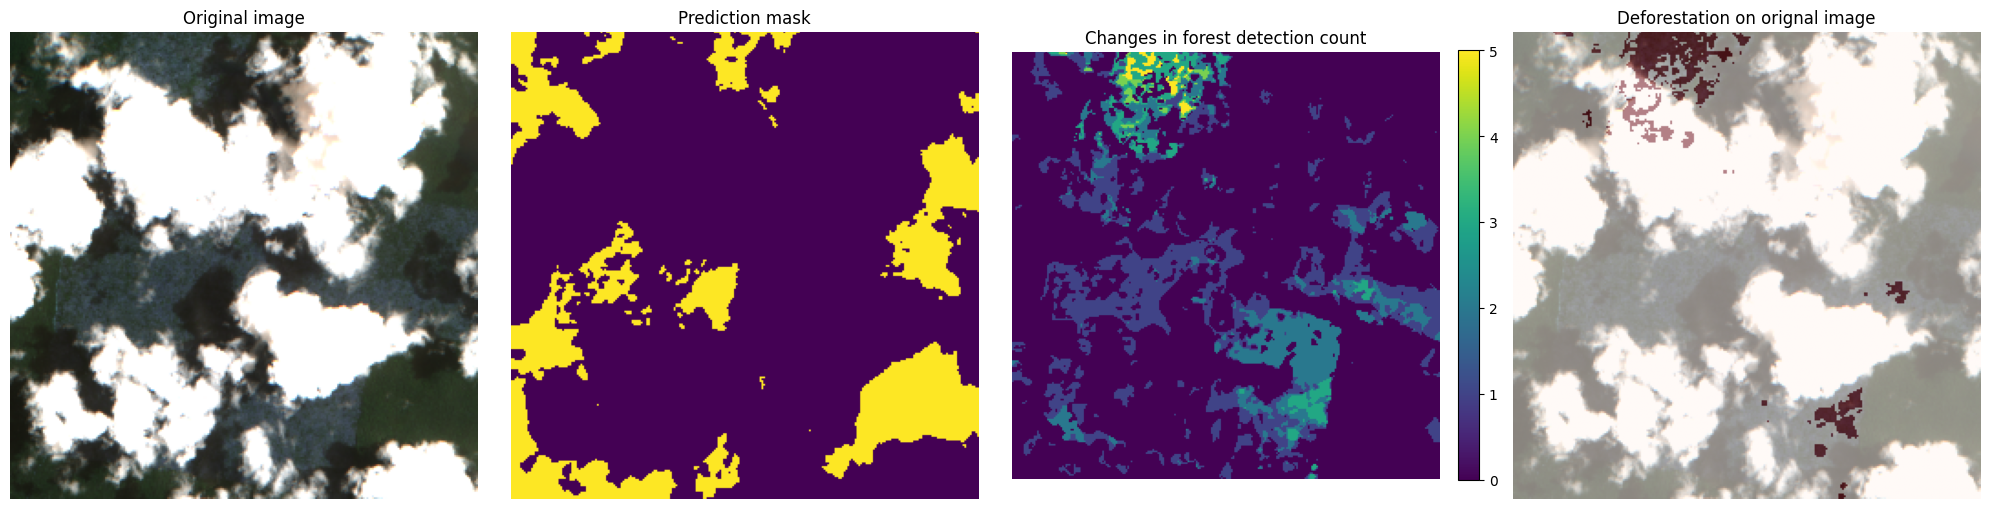

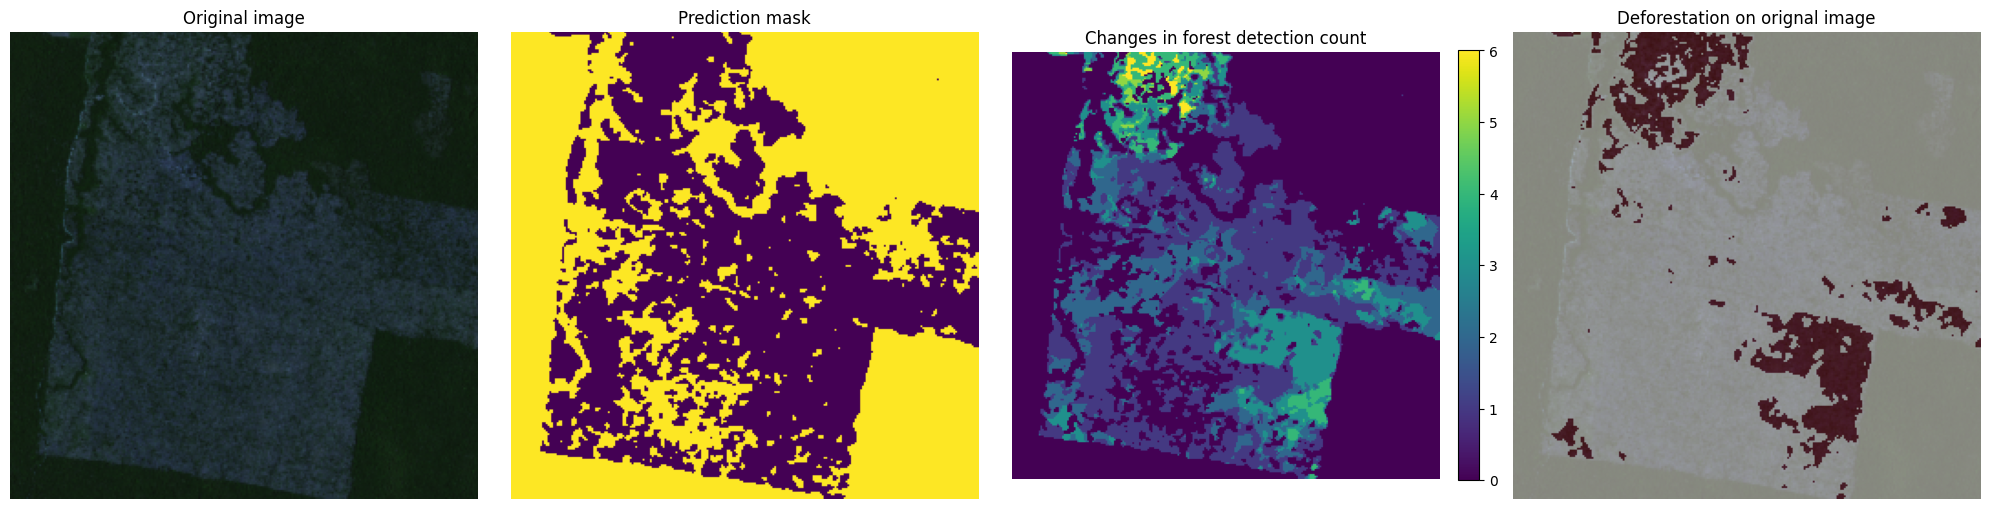

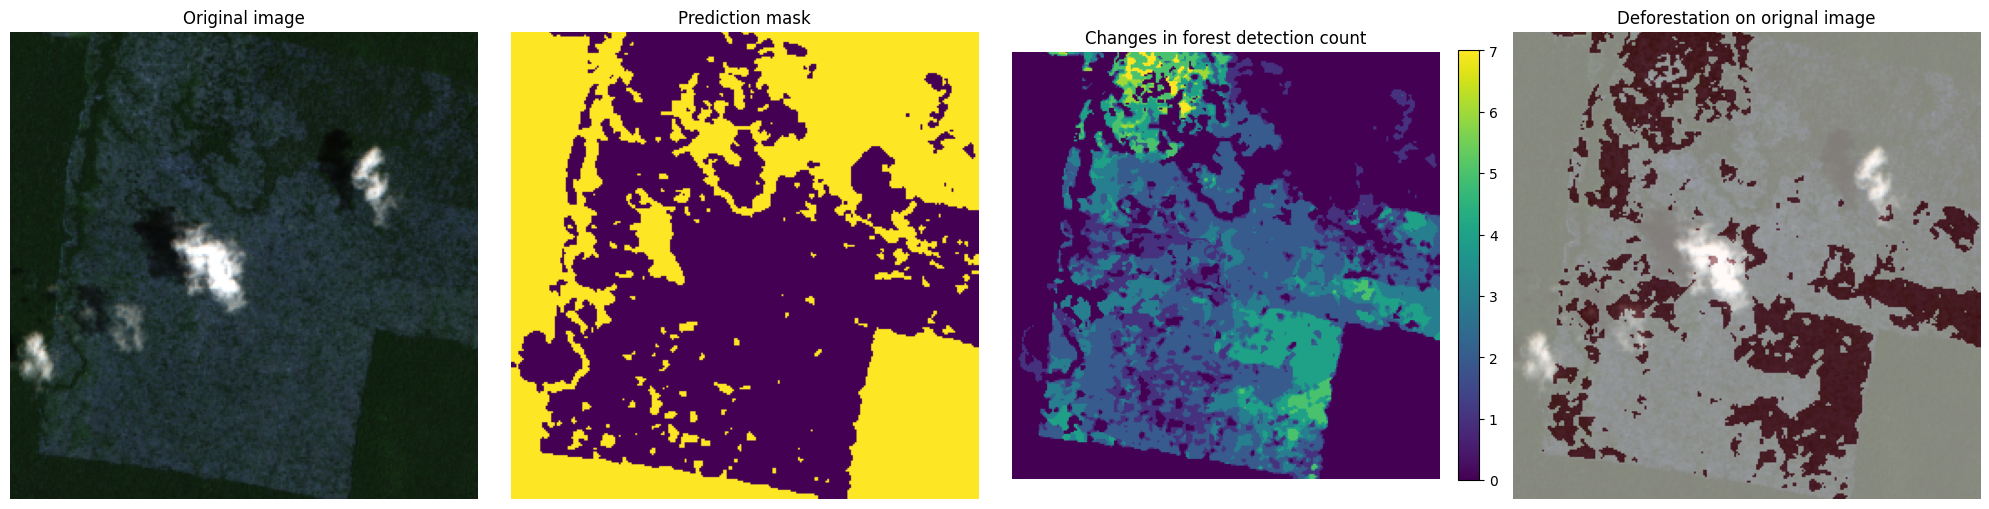

In [29]:
find_deforestation(deforestation_images[2], cloud_masks[2], unetplusplus,device)